In [1]:
# mount to Google drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/learn/mlflow')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# install and import mlflow
import importlib

if importlib.util.find_spec('mlflow') is None:
  !pip install mlflow

import os
import pandas as pd

import mlflow

In [4]:
# setting mlflow artefacts
artefacts_temp_dir = 'artefacts_mlflow'
if not os.path.exists(artefacts_temp_dir):
    os.makedirs(artefacts_temp_dir)

mlflow.create_experiment('Iris Classification')

'1'

## Define models

In [5]:
import pickle

import matplotlib.pyplot as plt
import mlflow
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from util import plot_confusion_matrix

In [6]:
mlflow.set_experiment('Iris Classification')

In [7]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

mlflow.log_param('dataset', 'iris')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(112, 4) (112,)
(38, 4) (38,)


## train and evaludate model

In [8]:
model_dict = {
    'decision_tree': DecisionTreeClassifier,
    'logistic_regression': LogisticRegression,
    'svm': SVC
}

In [9]:
def ml_model_train_eval(model_dict, model_name, X_train, y_train, X_test, y_test):
  ModelClass = model_dict[model_name]
  model = ModelClass()

  # mlflow.log_param('model_name', model_name)
  model.fit(X_train, y_train)


  model_file_name = f'./{artefacts_temp_dir}/{model_name}.pkl'
  with open(model_file_name, 'wb') as f:
      pickle.dump(model, f)
      
  mlflow.log_artifact(model_file_name)
  acc = model.score(X_test, y_test)

  mlflow.log_metric('accuracy', acc)

  y_pred = model.predict(X_test)
  figure = plot_confusion_matrix(y_test, y_pred, class_names)
  figure.show()

  confusion_matrix_file_name = f'{artefacts_temp_dir}/{model_name}_confusion_matrix.png'
  figure.savefig(confusion_matrix_file_name)
  mlflow.log_artifact(confusion_matrix_file_name)

#MLFlow run

Running 'decision_tree' model
Running 'logistic_regression' model


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Running 'svm' model


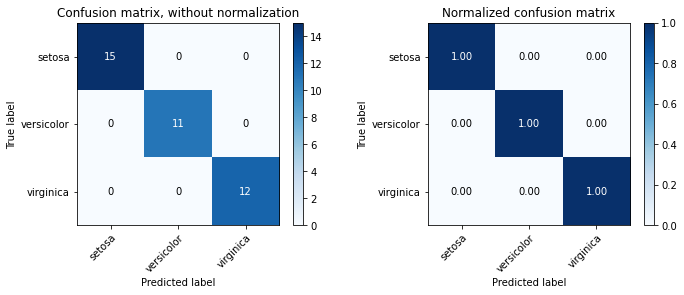

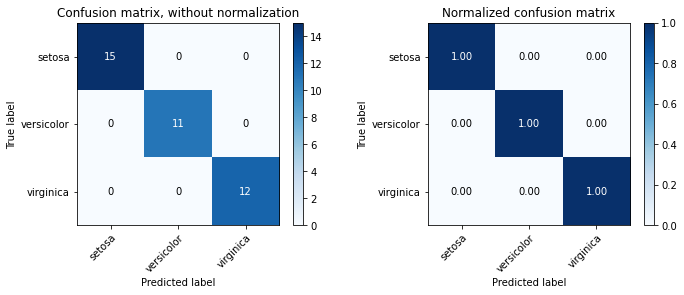

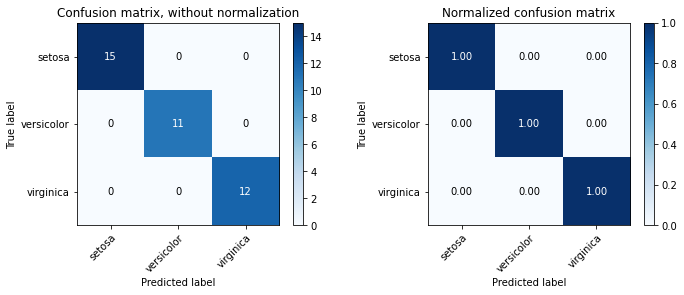

In [10]:
model_list = ['decision_tree', 'logistic_regression', 'svm']

for model_name in model_list:
  print(f"Running {model_name!r} model")

  now = str(pd.to_datetime('now'))

  ml_model_train_eval(model_dict, model_name, X_train, y_train, X_test, y_test)

# Set mlflow UI 

no direct link from mlfow ui to google colab/drive yet. I used `pyngrok` to route. learnt from https://github.com/mlflow/mlflow/issues/2350 

In [15]:
get_ipython().system_raw("mlflow ui --port 5000 &")# run tracking UI in the background

In [16]:
!pip install pyngrok --quiet
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
public_url = ngrok.connect(port="5000", proto="http", options={"bind_tls": True})
print("MLflow Tracking UI:", public_url)

MLflow Tracking UI: https://3bd31b9a2762.ngrok.io
